In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-05-24 07:05:27.896368: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [6]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
from config import *
import json

import os
os.system("rm /mnt/data/Trading/Datasets/*")

0

In [7]:
def intervalToMilliseconds(interval):
    """Convert a Binance interval string to milliseconds

    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str

    :return:
        None if unit not one of m, h, d or w
        None if string not in correct format
        int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms= int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

In [8]:
path = "18-01-01-00-00-23-05-20-05-55-1h" #

table = np.load( os.path.join( Config['BinanceCandlesNumpy'], "table-" + path + ".npy") )
table = np.swapaxes(table, 0, 1)
print("table: {}".format(table.shape))

table: (47137, 336, 10)


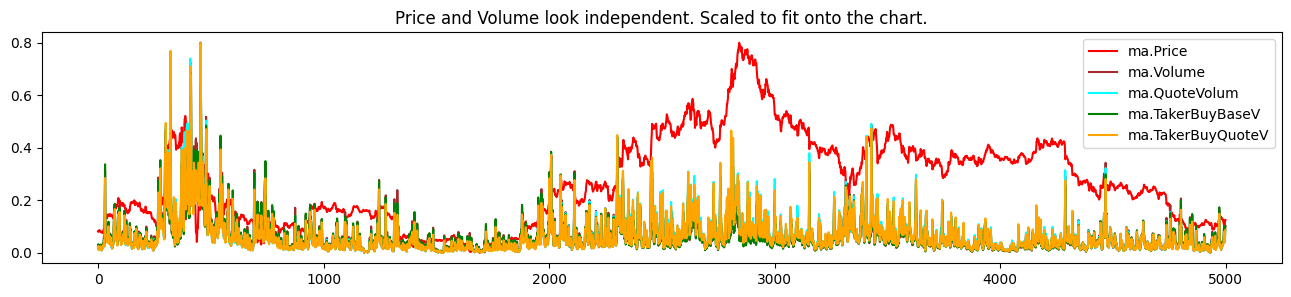

In [9]:
from Mike_NB_01 import *

market = 5
Show_Price_Volume_10(table[:, market, :], 1, 1, 5000)

In [10]:
marks = table[:, :, 9] # keep it for later use

table = np.delete(table, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, Marks

from enum import Enum
class Fields(Enum):
    Close = 0       # closing price
    Volume = 1      # base volume
    bVolume = 2     # buyer base volume

table_markets = []
with open( os.path.join( Config['BinanceCandlesNumpy'], "reports-" + path + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

markets = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert table.shape[1] == len(markets)
print(table.shape, len(markets), markets[:2])

['ALICEUSDT: 47137, 28074 created. Success.', 'DOTUSDT: 47137, 23082 created. Success.']
(47137, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [11]:
# restore timestamps

start = datetime( 2000+int(path[0:2]), int(path[3:5]), int(path[6:8]), int(path[9:11]), int(path[12:14]) )
start_ts = round(datetime.timestamp(start))
interval = path[ path.find('-', len(path) - 4) + 1 : ]
interval_s = round(intervalToMilliseconds(interval) / 1000)
timestamps = np.array( range(start_ts, start_ts + table.shape[0] * interval_s, interval_s), dtype=int)
assert timestamps.shape[0] == table.shape[0]
print(start_ts, interval_s, timestamps.shape, timestamps[:3])

1514764800 3600 (47137,) [1514764800 1514768400 1514772000]


In [12]:
# # Find market clusters
# from sklearn.metrics import pairwise

# distances = np.zeros( (table.shape[1], table.shape[1]), dtype=float)

# # Find dependency distance
# for m in range(table.shape[1]):
#     distances[m, m] = 0.
#     for n in range(m+1, table.shape[1]):
#         mask = (marks[:, m] + marks[:, n] == 0) # marks == 0 : true full candles, marks = -1: price interpolated , marks = -2: coincodex prices
#         pm = table[mask, m, 0][np.newaxis]
#         pn = table[mask, n, 0][np.newaxis]
#         distances[m, n] = sklearn.metrics.pairwise.cosine_distances(pm, pn)
#         distances[n, m] = distances[m, n]

In [13]:
# from sklearn.cluster import OPTICS
# clustering = OPTICS(metric='precomputed', n_jobs=-1).fit(distances)
# print( clustering.labels_ )

# np.reshape(np.argwhere(clustering.labels_ == 1), -1)

# market_clusters = [ [ markets[ id ] for id in np.reshape(np.argwhere(clustering.labels_ == label), -1) ] for label in range(np.max(clustering.labels_))]
# print(market_clusters)

In [14]:
# cluster = 0
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 0. Recent prices are mediocre. Shorter history.", series, color = 'auto')

In [15]:
# cluster = 1
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 1. Vanished recently. Shorter history, Trends later", series, color = 'auto')

In [16]:
# cluster = 2
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 2. Not vanished recently. Longer hostory. Trends earlier", series, color = 'auto')

In [17]:
def save_to_multiple_csv_files(data, sample_anchors, name_prefix, Nx, x_indices, Ny, y_indices, header=None, n_parts=10):
    training_dir = os.path.join("/mnt/data/Trading", "Datasets")
    os.makedirs(training_dir, exist_ok=True)
    path_format = os.path.join(training_dir, "{}_{:02d}.csv")

    filenames = []
    for file_idx, anchors in enumerate(np.array_split(sample_anchors, n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for anchor in anchors:
                x = np.reshape(data[anchor: anchor + Nx][:, x_indices[0]][:, :, x_indices[1]], -1)
                f.write(",".join([str(col) for col in x]))
                y = np.reshape(data[anchor + Nx: anchor + Nx + Ny][:, y_indices[0]][:, :, y_indices[1]], -1)
                f.write("," + ",".join([str(col) for col in y]))
                f.write("\n")
    return filenames

In [18]:
def parse_csv_line(line, Nx, size_x, Ny, size_y):
    print(line)
    defs = [tf.constant(0.0)] * (Nx * size_x + Ny * size_y)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack( tf.reshape(fields[: Nx * size_x], [Nx, -1] ) )    # sequence of Nx tokens, each of size_x
    y = tf.stack(fields[Nx * size_x :])
    return x, y

In [19]:
def csv_reader_dataset(filenames, Nx, size_x, Ny, size_y, n_parse_threads=5, batch_size=2, shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    # dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename), #.skip(1),
        cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(lambda x: parse_csv_line(x, Nx, size_x, Ny, size_y), num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset #.prefetch(1)

In [20]:
def get_timepoint_size(indices):
    size = 1
    for ids in indices:
        size *= len(ids)
    return size

In [21]:
# defind Data

n_times = 1000; n_markets = 2; n_fields = 2
Data = [ [ [ time * n_markets * n_fields + market * n_fields + field for field in range(n_fields) ] for market in range(n_markets) ] for time in range(n_times)]
Data = np.array(Data, dtype=float)
print(Data.shape)   # time, market, field
print(Data[:2, :, :])

(1000, 2, 2)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [22]:
Nx = 2
Ny = 2
Ns = 10
BatchSize = 2

sample_anchors = range(0, Data.shape[0] - Nx - Ny, Ns)
print(Data.shape[0], len(sample_anchors), sample_anchors)

x_indices = ( (0, 1), (0, 1) )    # (market, field)
y_indices = ( (0,), (0, 1) )    # (market, field)
print(Data[0:2][:, x_indices[0]][:, :, x_indices[1]])
print(Data[2:4][:, y_indices[0]][:, :, y_indices[1]])

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

1000 100 range(0, 996, 10)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
[[[ 8.  9.]]

 [[12. 13.]]]
4 2


In [23]:
filenames = save_to_multiple_csv_files(Data, sample_anchors, path + '_o', Nx, x_indices, Ny, y_indices, header=None, n_parts=10)
print(filenames)

['/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_00.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_01.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_02.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_03.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_04.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_05.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_06.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_07.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_08.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_09.csv']


In [24]:
filename_dataset = tf.data.Dataset.list_files(filenames, shuffle=None) # no way to prevent shuffle.
print(filename_dataset.cardinality().numpy())
for element in filename_dataset:
    print(element.numpy())

10
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_06.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_07.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_01.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_02.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_00.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_05.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_08.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_09.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_03.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_o_04.csv'


2023-05-24 07:05:30.352064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 07:05:31.016615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35045 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [25]:
ds = tf.data.TextLineDataset(filenames[0])
for line in ds.take(20):
    print(line.numpy())

b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,52.0,53.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,92.0,93.0'
b'120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,132.0,133.0'
b'160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,172.0,173.0'
b'200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,212.0,213.0'
b'240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,248.0,249.0,252.0,253.0'
b'280.0,281.0,282.0,283.0,284.0,285.0,286.0,287.0,288.0,289.0,292.0,293.0'
b'320.0,321.0,322.0,323.0,324.0,325.0,326.0,327.0,328.0,329.0,332.0,333.0'
b'360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,372.0,373.0'


In [26]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=n_readers, num_parallel_calls=tf.data.AUTOTUNE) # no way to prevent shuffle?

for line in dataset.take(15):
    print(line.numpy())

b'1200.0,1201.0,1202.0,1203.0,1204.0,1205.0,1206.0,1207.0,1208.0,1209.0,1212.0,1213.0'
b'400.0,401.0,402.0,403.0,404.0,405.0,406.0,407.0,408.0,409.0,412.0,413.0'
b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0'
b'3200.0,3201.0,3202.0,3203.0,3204.0,3205.0,3206.0,3207.0,3208.0,3209.0,3212.0,3213.0'
b'2400.0,2401.0,2402.0,2403.0,2404.0,2405.0,2406.0,2407.0,2408.0,2409.0,2412.0,2413.0'
b'1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,1248.0,1249.0,1252.0,1253.0'
b'440.0,441.0,442.0,443.0,444.0,445.0,446.0,447.0,448.0,449.0,452.0,453.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,52.0,53.0'
b'3240.0,3241.0,3242.0,3243.0,3244.0,3245.0,3246.0,3247.0,3248.0,3249.0,3252.0,3253.0'
b'2440.0,2441.0,2442.0,2443.0,2444.0,2445.0,2446.0,2447.0,2448.0,2449.0,2452.0,2453.0'
b'1280.0,1281.0,1282.0,1283.0,1284.0,1285.0,1286.0,1287.0,1288.0,1289.0,1292.0,1293.0'
b'480.0,481.0,482.0,483.0,484.0,485.0,486.0,487.0,488.0,489.0,492.0,493.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.

In [27]:
parse_csv_line(b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.', Nx, size_x, Ny, size_y)

b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.'


(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[0., 1., 2., 3.],
        [4., 5., 6., 7.]], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 8.,  9., 10., 11.], dtype=float32)>)

In [28]:
Dataset = csv_reader_dataset(filenames, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=5)

Tensor("args_0:0", shape=(), dtype=string)


In [29]:
for element in Dataset:
    print(element)
    break

# should print: (None, Nx, size_x), (None, Ny * size_y)

(<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[3640., 3641., 3642., 3643.],
        [3644., 3645., 3646., 3647.]],

       [[ 720.,  721.,  722.,  723.],
        [ 724.,  725.,  726.,  727.]]], dtype=float32)>, <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[3648., 3649., 3652., 3653.],
       [ 728.,  729.,  732.,  733.]], dtype=float32)>)


In [30]:
print(table.shape, x_indices)
table1 = table[:, x_indices[0]]
print(table1.shape)

(47137, 336, 3) ((0, 1), (0, 1))
(47137, 2, 3)


In [31]:
# Check elements: NaN, -inf, +inf

assert (~np.isfinite(table)).any() == False

In [32]:
# Logarithmize + Smoothen


In [33]:
# Trim in time dimension

In [34]:
# Normalize (linear)

In [35]:
# Add features, including time-info

hourly = np.sin( 2 * np.pi / (60*60) * timestamps )
daily = np.sin( 2 * np.pi / (60*60*24) * timestamps )
weekly = np.sin( 2 * np.pi / (60*60*24*7) * timestamps )
yearly = np.sin( 2 * np.pi / (60*60*24*365) * timestamps )


# A normalized representation of 'timestamps'
time_of_year_sin = np.sign( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_year_cos = np.cos( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_week_sin = np.sign( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_week_cos = np.cos( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_day_sin = np.sign( 2 * np.pi / (60*60*24) * timestamps )
time_of_day_cos = np.cos( 2 * np.pi / (60*60*24) * timestamps )

print(table.shape, hourly.shape)

# table = np.insert(table, 0, hourly.reshape(1), axis=0)

(47137, 336, 3) (47137,)


In [36]:
# Define Data
enFields = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

# dot, 1inch, btc, eth, matic, bnb, ada, sol, ltc, avax, wbtc, link, arb, ape, aave, crv, sui, op, gmx, agix, bal, comp, gmt, joe, stg
chosen_markets_x = ['DOTUSDT', '1INCHUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'SOLUSDT', 'LTCUSDT', 'AVAXUSDT', 'WBTCUSDT', 'LINKUSDT', 
                   'ARBUSDT', 'APEUSDT', 'SUIUSDT', 'OPUSDT', 'GMXUSDT', 'AGIXUSDT', 'BALUSDT', 'COMPUSDT', 'GMTUSDT', 'JOEUSDT', 'STGUSDT']
chosen_markets_x = tuple([ markets.index(elem) for elem in chosen_markets_x ])
chosen_fields_x = ['ClosePrice', 'BaseVolume']
chosen_fields_x = tuple( [ enFields.index(elem) for elem in chosen_fields_x ] )
x_indices = ( chosen_markets_x, chosen_fields_x )
print(x_indices)

chosen_markets_y = ['BTCUSDT',] # 'ETHUSDT', 'BNBUSDT', 'AVAXUSDT', 'LINKUSDT']
chosen_markets_y = tuple([ markets.index(elem) for elem in chosen_markets_y ])
chosen_fields_y = ['ClosePrice']
chosen_fields_y = tuple( [ enFields.index(elem) for elem in chosen_fields_y ] )
y_indices = ( chosen_markets_y, chosen_fields_y )
print(y_indices)

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

((1, 2, 3, 4, 6, 8, 10, 11, 15, 16, 17, 30, 32, 56, 59, 61, 77, 94, 95, 104, 154, 156), (0, 1))
((3,), (0,))
44 1


In [37]:
Data = table[:, :, :]

import numpy as np
from sklearn.model_selection import train_test_split

Train, Valid = train_test_split(Data, test_size=0.30, random_state=42)
print(Train.shape, Valid.shape)

(32995, 336, 3) (14142, 336, 3)


In [38]:
Nx = 100
Ny = 5
Ns = 3
BatchSize = 100

sample_anchors_t = range(0, Train.shape[0] - Nx - Ny + 1, Ns)
print(Train.shape[0], len(sample_anchors_t), sample_anchors_t, sample_anchors_t[-1])
print(Data.shape[0], sample_anchors_t[ -1 ], sample_anchors_t[ -1 ] + Nx + Ny, sample_anchors_t[ -1 ] + Ns, sample_anchors_t[ -1 ] + Ns + Nx + Ny)

sample_anchors_v = range(0, Valid.shape[0] - Nx - Ny + 1, Ns)
print(Valid.shape[0], len(sample_anchors_v), sample_anchors_v, sample_anchors_v[-1])
print(Data.shape[0], sample_anchors_v[ -1 ], sample_anchors_v[ -1 ] + Nx + Ny, sample_anchors_v[ -1 ] + Ns, sample_anchors_v[ -1 ] + Ns + Nx + Ny)

32995 10964 range(0, 32891, 3) 32889
47137 32889 32994 32892 32997
14142 4680 range(0, 14038, 3) 14037
47137 14037 14142 14040 14145


In [39]:
filenames_train = save_to_multiple_csv_files(Train, sample_anchors_t, path + '_t', Nx, x_indices, Ny, y_indices, header=None, n_parts=1)
filenames_valid = save_to_multiple_csv_files(Valid, sample_anchors_v, path + '_v', Nx, x_indices, Ny, y_indices, header=None, n_parts=1)


In [40]:
Dataset_train = csv_reader_dataset(filenames_train, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=1)
Dataset_train = Dataset_train.prefetch(1)
# print(len(Dataset_train))

Dataset_valid = csv_reader_dataset(filenames_valid, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=1)
Dataset_valid = Dataset_valid.prefetch(1)
# print(len(Dataset_valid))


Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


In [41]:
for element in Dataset_train:
    print(element)
    break


(<tf.Tensor: shape=(100, 100, 44), dtype=float32, numpy=
array([[[3.1816401e+01, 8.0348050e+05, 3.8478000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [5.6300001e+00, 4.9783047e+05, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [7.3000002e+00, 2.1018819e+05, 6.8800002e-01, ...,
         9.8853891e+04, 0.0000000e+00, 0.0000000e+00],
        [1.0473800e+01, 1.1796352e+06, 1.2068000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.4400000e+01, 4.8599719e+05, 1.2280000e+00, ...,
         2.9714116e+05, 0.0000000e+00, 0.0000000e+00]],

       [[5.0114999e+00, 3.5026803e+05, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.00000

In [42]:
input_dim = size_x
units = input_dim
output_size = Ny * size_y

print(input_dim, units, output_size)

def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim), return_sequences=True )
        lstm_layer1 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer2 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer3 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer4 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer5 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer6 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer7 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer8 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer9 = keras.layers.LSTM(units, input_shape=(None, units) )

    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(None, input_dim), return_sequences=True)

    # with mirrored_strategy.scope():
    model = keras.models.Sequential(
        [
            lstm_layer,
            # lstm_layer1,
            # lstm_layer2,
            # lstm_layer3,
            # lstm_layer4,
            # lstm_layer5,
            # lstm_layer6,
            # lstm_layer7,
            # lstm_layer8,
            lstm_layer9,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )

    model.compile(
        loss=keras.losses.MSE,
        optimizer="adam",
        # metrics=keras.metrics.MSE,
    )

    return model

44 44 5


In [43]:
model = build_model(allow_cudnn_kernel=True)
# model.summary()
# keras.utils.plot_model(model, show_shapes=True)

In [44]:
# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# train_data = Dataset_train.with_options(options)
# val_data = Dataset_valid.with_options(options)

history = model.fit(Dataset_train, validation_data=Dataset_valid, epochs=1000)

Epoch 1/1000


2023-05-24 07:06:09.989482: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-05-24 07:06:11.456708: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


110/110 [==============================] - 30s 193ms/step - loss: 696809664.0000 - val_loss: 695157952.0000
Epoch 2/1000
110/110 [==============================] - 17s 152ms/step - loss: 696733632.0000 - val_loss: 695055424.0000
Epoch 3/1000
110/110 [==============================] - 26s 230ms/step - loss: 696542400.0000 - val_loss: 695096576.0000
Epoch 4/1000
110/110 [==============================] - 17s 151ms/step - loss: 696222592.0000 - val_loss: 694416384.0000
Epoch 5/1000
110/110 [==============================] - 17s 149ms/step - loss: 695773632.0000 - val_loss: 693859136.0000
Epoch 6/1000
110/110 [==============================] - 26s 233ms/step - loss: 695206400.0000 - val_loss: 695256704.0000
Epoch 7/1000
110/110 [==============================] - 17s 149ms/step - loss: 694535872.0000 - val_loss: 692032448.0000
Epoch 8/1000
110/110 [==============================] - 17s 149ms/step - loss: 693773632.0000 - val_loss: 688245440.0000
Epoch 9/1000
110/110 [=======================

110/110 [==============================] - 27s 237ms/step - loss: 540529536.0000 - val_loss: 541189312.0000
Epoch 69/1000
110/110 [==============================] - 17s 149ms/step - loss: 536805728.0000 - val_loss: 579018432.0000
Epoch 70/1000
110/110 [==============================] - 17s 148ms/step - loss: 533191680.0000 - val_loss: 533392896.0000
Epoch 71/1000
110/110 [==============================] - 27s 237ms/step - loss: 529451552.0000 - val_loss: 538668864.0000
Epoch 72/1000
110/110 [==============================] - 17s 148ms/step - loss: 526064992.0000 - val_loss: 552158080.0000
Epoch 73/1000
110/110 [==============================] - 17s 149ms/step - loss: 522376448.0000 - val_loss: 542227776.0000
Epoch 74/1000
110/110 [==============================] - 24s 204ms/step - loss: 519061056.0000 - val_loss: 522830304.0000
Epoch 75/1000
110/110 [==============================] - 17s 149ms/step - loss: 515421600.0000 - val_loss: 523871552.0000
Epoch 76/1000
110/110 [===============

Epoch 135/1000
110/110 [==============================] - 21s 181ms/step - loss: 317369056.0000 - val_loss: 356391744.0000
Epoch 136/1000
110/110 [==============================] - 18s 157ms/step - loss: 314015008.0000 - val_loss: 357037984.0000
Epoch 137/1000
110/110 [==============================] - 25s 219ms/step - loss: 311885344.0000 - val_loss: 344327104.0000
Epoch 138/1000
110/110 [==============================] - 18s 153ms/step - loss: 309236928.0000 - val_loss: 351186208.0000
Epoch 139/1000
110/110 [==============================] - 18s 157ms/step - loss: 307555680.0000 - val_loss: 346250208.0000
Epoch 140/1000
110/110 [==============================] - 26s 232ms/step - loss: 303976288.0000 - val_loss: 343842176.0000
Epoch 141/1000
110/110 [==============================] - 17s 149ms/step - loss: 301859488.0000 - val_loss: 341481184.0000
Epoch 142/1000
110/110 [==============================] - 17s 148ms/step - loss: 299355392.0000 - val_loss: 342129536.0000
Epoch 143/1000
1

110/110 [==============================] - 26s 231ms/step - loss: 241267472.0000 - val_loss: 295708864.0000
Epoch 202/1000
110/110 [==============================] - 17s 149ms/step - loss: 241150240.0000 - val_loss: 295411776.0000
Epoch 203/1000
110/110 [==============================] - 17s 149ms/step - loss: 241276432.0000 - val_loss: 298980960.0000
Epoch 204/1000
110/110 [==============================] - 26s 232ms/step - loss: 241815120.0000 - val_loss: 297238656.0000
Epoch 205/1000
110/110 [==============================] - 17s 148ms/step - loss: 240920160.0000 - val_loss: 298912960.0000
Epoch 206/1000
110/110 [==============================] - 17s 150ms/step - loss: 241091744.0000 - val_loss: 298405280.0000
Epoch 207/1000
110/110 [==============================] - 26s 234ms/step - loss: 240459744.0000 - val_loss: 300426912.0000
Epoch 208/1000
110/110 [==============================] - 17s 150ms/step - loss: 241391232.0000 - val_loss: 297486432.0000
Epoch 209/1000
110/110 [=======

110/110 [==============================] - 17s 151ms/step - loss: 236561760.0000 - val_loss: 301495712.0000
Epoch 268/1000
110/110 [==============================] - 17s 150ms/step - loss: 236787216.0000 - val_loss: 302129344.0000
Epoch 269/1000
110/110 [==============================] - 26s 234ms/step - loss: 237189536.0000 - val_loss: 300947040.0000
Epoch 270/1000
110/110 [==============================] - 17s 149ms/step - loss: 236009216.0000 - val_loss: 301843552.0000
Epoch 271/1000
110/110 [==============================] - 17s 150ms/step - loss: 236362480.0000 - val_loss: 302767648.0000
Epoch 272/1000
110/110 [==============================] - 26s 234ms/step - loss: 236608368.0000 - val_loss: 300287392.0000
Epoch 273/1000
110/110 [==============================] - 17s 150ms/step - loss: 235586736.0000 - val_loss: 301334976.0000
Epoch 274/1000
110/110 [==============================] - 17s 149ms/step - loss: 236154544.0000 - val_loss: 302051936.0000
Epoch 275/1000
110/110 [=======

110/110 [==============================] - 22s 190ms/step - loss: 231438512.0000 - val_loss: 304457504.0000
Epoch 334/1000
110/110 [==============================] - 17s 149ms/step - loss: 232177904.0000 - val_loss: 304912704.0000
Epoch 335/1000
110/110 [==============================] - 23s 204ms/step - loss: 232699424.0000 - val_loss: 305854752.0000
Epoch 336/1000
110/110 [==============================] - 20s 171ms/step - loss: 231838256.0000 - val_loss: 305866464.0000
Epoch 337/1000
110/110 [==============================] - 17s 153ms/step - loss: 232197232.0000 - val_loss: 306239616.0000
Epoch 338/1000
110/110 [==============================] - 27s 235ms/step - loss: 231559728.0000 - val_loss: 305450496.0000
Epoch 339/1000
110/110 [==============================] - 17s 150ms/step - loss: 231412656.0000 - val_loss: 307709856.0000
Epoch 340/1000
110/110 [==============================] - 17s 150ms/step - loss: 232396448.0000 - val_loss: 305798496.0000
Epoch 341/1000
110/110 [=======

110/110 [==============================] - 26s 232ms/step - loss: 230805664.0000 - val_loss: 308932640.0000
Epoch 400/1000
110/110 [==============================] - 17s 149ms/step - loss: 230005392.0000 - val_loss: 306765376.0000
Epoch 401/1000
110/110 [==============================] - 17s 150ms/step - loss: 230489920.0000 - val_loss: 308712128.0000
Epoch 402/1000
110/110 [==============================] - 26s 235ms/step - loss: 229648208.0000 - val_loss: 309374016.0000
Epoch 403/1000
110/110 [==============================] - 17s 149ms/step - loss: 230275376.0000 - val_loss: 306986304.0000
Epoch 404/1000
110/110 [==============================] - 17s 149ms/step - loss: 229202016.0000 - val_loss: 307834656.0000
Epoch 405/1000
110/110 [==============================] - 27s 237ms/step - loss: 229180304.0000 - val_loss: 310228192.0000
Epoch 406/1000
110/110 [==============================] - 17s 149ms/step - loss: 229453824.0000 - val_loss: 308791936.0000
Epoch 407/1000
110/110 [=======

110/110 [==============================] - 27s 238ms/step - loss: 225684560.0000 - val_loss: 313813376.0000
Epoch 466/1000
110/110 [==============================] - 17s 149ms/step - loss: 225589712.0000 - val_loss: 311071456.0000
Epoch 467/1000
110/110 [==============================] - 17s 150ms/step - loss: 225097344.0000 - val_loss: 313448704.0000
Epoch 468/1000
110/110 [==============================] - 26s 230ms/step - loss: 227422880.0000 - val_loss: 313166688.0000
Epoch 469/1000
110/110 [==============================] - 17s 150ms/step - loss: 225233920.0000 - val_loss: 309747680.0000
Epoch 470/1000
110/110 [==============================] - 21s 189ms/step - loss: 227425984.0000 - val_loss: 312318176.0000
Epoch 471/1000
110/110 [==============================] - 22s 187ms/step - loss: 225585616.0000 - val_loss: 311444192.0000
Epoch 472/1000
110/110 [==============================] - 17s 149ms/step - loss: 224963280.0000 - val_loss: 311591264.0000
Epoch 473/1000
110/110 [=======

110/110 [==============================] - 17s 150ms/step - loss: 220730224.0000 - val_loss: 314998336.0000
Epoch 532/1000
110/110 [==============================] - 26s 235ms/step - loss: 220754368.0000 - val_loss: 316166688.0000
Epoch 533/1000
110/110 [==============================] - 17s 149ms/step - loss: 220848480.0000 - val_loss: 316691616.0000
Epoch 534/1000
110/110 [==============================] - 17s 151ms/step - loss: 221343840.0000 - val_loss: 315336544.0000
Epoch 535/1000
110/110 [==============================] - 26s 234ms/step - loss: 222041760.0000 - val_loss: 314132640.0000
Epoch 536/1000
110/110 [==============================] - 17s 150ms/step - loss: 229874224.0000 - val_loss: 315378368.0000
Epoch 537/1000
110/110 [==============================] - 17s 150ms/step - loss: 224157984.0000 - val_loss: 313120768.0000
Epoch 538/1000
110/110 [==============================] - 26s 235ms/step - loss: 223166912.0000 - val_loss: 316565312.0000
Epoch 539/1000
110/110 [=======

110/110 [==============================] - 17s 151ms/step - loss: 218750400.0000 - val_loss: 317689216.0000
Epoch 598/1000
110/110 [==============================] - 26s 231ms/step - loss: 220731744.0000 - val_loss: 313581888.0000
Epoch 599/1000
110/110 [==============================] - 17s 151ms/step - loss: 218430336.0000 - val_loss: 319135136.0000
Epoch 600/1000
110/110 [==============================] - 17s 151ms/step - loss: 216640832.0000 - val_loss: 316795712.0000
Epoch 601/1000
110/110 [==============================] - 26s 234ms/step - loss: 216939440.0000 - val_loss: 318540896.0000
Epoch 602/1000
110/110 [==============================] - 17s 150ms/step - loss: 216518128.0000 - val_loss: 318356192.0000
Epoch 603/1000
110/110 [==============================] - 17s 151ms/step - loss: 217585696.0000 - val_loss: 320647040.0000
Epoch 604/1000
110/110 [==============================] - 26s 235ms/step - loss: 217044992.0000 - val_loss: 318507840.0000
Epoch 605/1000
110/110 [=======

110/110 [==============================] - 17s 151ms/step - loss: 213837344.0000 - val_loss: 318826464.0000
Epoch 664/1000
110/110 [==============================] - 23s 207ms/step - loss: 216832752.0000 - val_loss: 321515456.0000
Epoch 665/1000
110/110 [==============================] - 20s 168ms/step - loss: 214673008.0000 - val_loss: 318408064.0000
Epoch 666/1000
110/110 [==============================] - 17s 150ms/step - loss: 215406720.0000 - val_loss: 323294816.0000
Epoch 667/1000
110/110 [==============================] - 26s 230ms/step - loss: 214581104.0000 - val_loss: 320986112.0000
Epoch 668/1000
110/110 [==============================] - 17s 151ms/step - loss: 212271440.0000 - val_loss: 321883840.0000
Epoch 669/1000
110/110 [==============================] - 17s 151ms/step - loss: 211921616.0000 - val_loss: 318857600.0000
Epoch 670/1000
110/110 [==============================] - 27s 238ms/step - loss: 212122672.0000 - val_loss: 321552928.0000
Epoch 671/1000
110/110 [=======

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

In [ ]:
# history_2= model.fit(Dataset_train, validation_data=Dataset_valid, epochs=10, initial epoch=history_1.epoch(-1) )